## Neural network, experimentation tool, version 2

EDIT: the scaling is now done separately for independent support variables and the target. The model works a bit better now.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# activation functions
# ReLu is very simple, it filters out all negative values
# this is a powerful activation function in reality
def activation_ReLu(number):
    if number > 0:
        return number
    else:
        return 0


# we also need a derivated version of ReLu
# otherwise same as original, but instead of original value, return 1 instead
def activation_ReLu_partial_derivative(number):
    if number > 0:
        return 1
    else:
        return 0

In [2]:
# lock down the randomness in order to get same results everytime
# you can change or disable this if you want
np.random.seed(123)

def generate_train_data():
    result = []

    # create 100 numbers
    for x in range(100):
        n1 = np.random.randint(0, 5)
        n2 = np.random.randint(3, 7)

        # formula for the target variable: x1 ^^ 2 + x2 + (random integer between 0-5)
        # the only point of this is to have some kind of logic in the data
        n3 = n1 ** 2 + n2 + np.random.randint(0, 5)
        n3 = int(n3)

        result.append([n1, n2, n3])


    return result


In [3]:
# use generated training data from our helper function
# data = generate_train_data()
# df = pd.DataFrame(data, columns=["x1", "x2", "y"])
df = pd.read_csv("medical_insurance.csv")
df = df[["age", "bmi", "charges"]]
df

,age,bmi,charges
0,19,27.900,16884.92400
1,18,33.770,1725.55230
2,28,33.000,4449.46200
3,33,22.705,21984.47061
4,32,28.880,3866.85520
...,...,...,...
2767,47,45.320,8569.86180
2768,21,34.600,2020.17700
2769,19,26.030,16450.89470
2770,23,18.715,21595.38229


In [4]:
# initialize weights and biases
# in Keras/TensorFlow/PyTorch etc. these are usually randomized in the beginning
w1 = 1
w2 = 0.5
w3 = 1
w4 = -0.5
w5 = 1
w6 = 1
bias1 = 0.5
bias2 = 0
bias3 = 0.5

# just for comparison after the training
original_w1 = w1
original_w2 = w2
original_w3 = w3
original_w4 = w4
original_w5 = w5
original_w6 = w6
original_b1 = bias1
original_b2 = bias2
original_b3 = bias3

# DataFrame values as a list
# data = list(df.values)
data = df.values

# use min/max -scaling to make values in the range 0-1

# independent support variables => indeces 0 and 1 (X)
# target variable => index 2 (y)
X = data[:, :2]
y = data[:, 2:]

# Scale X and y
X_scaled = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))
y_scaled = (y - np.min(y, axis=0)) / (np.max(y, axis=0) - np.min(y, axis=0))

# combine back to original data format
data = np.hstack((X_scaled, y_scaled))

# learning rate
LR = 0.005
epochs = 300

# let's initalize a list for loss visualizations
loss_points = []

for epoch in range(epochs):

    # the previous version only measured the loss value
    # of the last calculation done in the code (node 3)
    # it's probably better to measure the average loss for each epoch
    epoch_losses = []

    for row in data:
        # this is where we do Forward pass + backpropagation
        input1 = row[0]
        input2 = row[1]
        true_value = row[2]

        # NODE 1 OUTPUT
        node_1_output = input1 * w1 + input2 * w3 + bias1
        node_1_output = activation_ReLu(node_1_output)
        node_1_output

        # NODE 2 OUTPUT
        node_2_output = input1 * w2 + input2 * w4 + bias2
        node_2_output = activation_ReLu(node_2_output)
        node_2_output

        # NODE 3 OUTPUT
        # we can just use Node 1 and 2 outputs, since they
        # already contain the previous weights in their result
        node_3_output = node_1_output * w5 + node_2_output * w6 + bias3
        node_3_output = activation_ReLu(node_3_output)
        node_3_output

        # LOSS FUNCTION - we are going to use MSE -> mean squared error
        # MSE formula for LOSS => (predicted_value - true_value) ^ 2
        predicted_value = node_3_output
        loss = (predicted_value - true_value) ** 2

        # add current loss into epoch losses -list
        epoch_losses.append(loss)
        
        # BACKPROPAGATION - LAST LAYER FIRST
        # solving the partial derivative of the loss function with respect to w5
        deriv_L_w5 = 2 * node_1_output * (node_1_output * w5 + node_2_output * w6 + bias3 - true_value)
        new_w5 = w5 - LR * deriv_L_w5

        deriv_L_w6 = 2 * node_2_output * (node_1_output * w5 + node_2_output * w6 + bias3 - true_value)
        new_w6 = w6 - LR * deriv_L_w6

        deriv_L_b3 = 2 * 1 * (node_1_output * w5 + node_2_output * w6 + bias3 - true_value)
        new_b3 = bias3 - LR * deriv_L_b3

        # BACKPROPAGATION - THE FIRST LAYER
        # FROM THIS POINT ONWARD WE HAVE TO USE THE MORE COMPLEX VERSION
        # OF UPDATING THE VALUES => CHAIN RULE

        # weight 1
        deriv_L_w1_left = 2 * w5 * (node_1_output * w5 + node_2_output * w6 + bias3 - true_value)
        deriv_L_w1_right = activation_ReLu_partial_derivative(input1 * w1 + input2 * w3 + bias1) * input1
        deriv_L_w1 = deriv_L_w1_left * deriv_L_w1_right
        new_w1 = w1 - LR * deriv_L_w1

        # weight 2
        deriv_L_w2_left = 2 * w6 * (node_1_output * w5 + node_2_output * w6 + bias3 - true_value)
        deriv_L_w2_right = activation_ReLu_partial_derivative(input1 * w2 + input2 * w4 + bias2) * input1
        deriv_L_w2 = deriv_L_w2_left * deriv_L_w2_right
        new_w2 = w2 - LR * deriv_L_w2

        # weight 3
        deriv_L_w3_left = 2 * w5 * (node_1_output * w5 + node_2_output * w6 + bias3 - true_value)
        deriv_L_w3_right = activation_ReLu_partial_derivative(input1 * w1 + input2 * w3 + bias1) * input2
        deriv_L_w3 = deriv_L_w3_left * deriv_L_w3_right
        new_w3 = w3 - LR * deriv_L_w3

        # weight 4
        deriv_L_w4_left = 2 * w6 * (node_1_output * w5 + node_2_output * w6 + bias3 - true_value)
        deriv_L_w4_right = activation_ReLu_partial_derivative(input1 * w2 + input2 * w4 + bias2) * input2
        deriv_L_w4 = deriv_L_w4_left * deriv_L_w4_right
        new_w4 = w4 - LR * deriv_L_w4

        # bias 1
        deriv_L_b1_left = 2 * w5 * (node_1_output * w5 + node_2_output * w6 + bias3 - true_value)
        deriv_L_b1_right = activation_ReLu_partial_derivative(input1 * w1 + input2 * w3 + bias1) * 1
        deriv_L_b1 = deriv_L_b1_left * deriv_L_b1_right
        new_b1 = bias1 - LR * deriv_L_b1

        # bias 2
        deriv_L_b2_left = 2 * w6 * (node_1_output * w5 + node_2_output * w6 + bias3 - true_value)
        deriv_L_b2_right = activation_ReLu_partial_derivative(input1 * w2 + input2 * w4 + bias2) * 1
        deriv_L_b2 = deriv_L_b2_left * deriv_L_b2_right
        new_b2 = bias2 - LR * deriv_L_b2

        # ALL DONE! FINALLY UPDATE THE EXISTING WEIGHTS
        w1 = new_w1
        w2 = new_w2
        w3 = new_w3
        w4 = new_w4
        w5 = new_w5
        w6 = new_w6
        bias1 = new_b1
        bias2 = new_b2
        bias3 = new_b3

    # calculate average epoch-wise loss and add it to loss points
    average_loss = sum(epoch_losses) / len(epoch_losses)

    # place the overall epoch loss into the loss_points list
    loss_points.append(average_loss)
    print(f"Epoch: {epoch + 1}, loss: {average_loss}")
        

Epoch: 1, loss: 0.05027569715117
Epoch: 2, loss: 0.03359019710766125
Epoch: 3, loss: 0.033568948716146234
Epoch: 4, loss: 0.033565053677841857
Epoch: 5, loss: 0.03356279467925406
Epoch: 6, loss: 0.03355813340490166
Epoch: 7, loss: 0.03355497301457527
Epoch: 8, loss: 0.033550098691783846
Epoch: 9, loss: 0.03354692811246641
Epoch: 10, loss: 0.0335449353817778
Epoch: 11, loss: 0.03354306104595482
Epoch: 12, loss: 0.033541245953323855
Epoch: 13, loss: 0.03353950522687489
Epoch: 14, loss: 0.03353787270434304
Epoch: 15, loss: 0.03353627186314619
Epoch: 16, loss: 0.03353470038073381
Epoch: 17, loss: 0.03353315710469112
Epoch: 18, loss: 0.03353164098996176
Epoch: 19, loss: 0.033530151072460726
Epoch: 20, loss: 0.03352868645785967
Epoch: 21, loss: 0.03352724631444429
Epoch: 22, loss: 0.033525829867343794
Epoch: 23, loss: 0.03352443639344974
Epoch: 24, loss: 0.03352306521683449
Epoch: 25, loss: 0.03352171570459257
Epoch: 26, loss: 0.03352038726306435
Epoch: 27, loss: 0.033519079334405705
Epoch: 

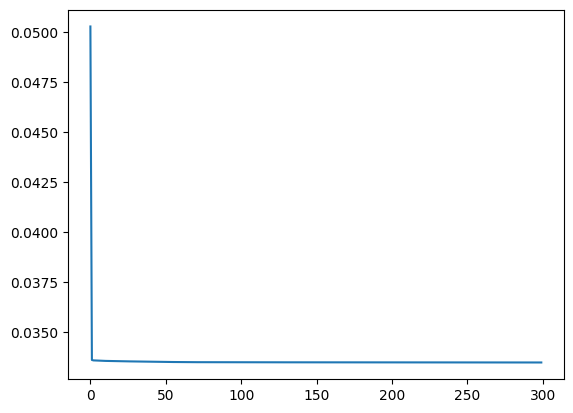

In [5]:
plt.plot(loss_points)
# plt.ylim(-1, 5)
plt.show()



In [6]:
print("ORIGINAL WEIGHTS AND BIASES")
print(f"w1: {original_w1}")
print(f"w2: {original_w2}")
print(f"w3: {original_w3}")
print(f"w4: {original_w4}")
print(f"w5: {original_w5}")
print(f"w6: {original_w6}")
print(f"b1: {original_b1}")
print(f"b2: {original_b2}")
print(f"b3: {original_b3}")

print("\n\n#################################\n\n")

print("NEW WEIGHTS AND BIASES")
print(f"w1: {new_w1}")
print(f"w2: {new_w2}")
print(f"w3: {new_w3}")
print(f"w4: {new_w4}")
print(f"w5: {new_w5}")
print(f"w6: {new_w6}")
print(f"b1: {new_b1}")
print(f"b2: {new_b2}")
print(f"b3: {new_b3}")



ORIGINAL WEIGHTS AND BIASES
w1: 1
w2: 0.5
w3: 1
w4: -0.5
w5: 1
w6: 1
b1: 0.5
b2: 0
b3: 0.5


#################################


NEW WEIGHTS AND BIASES
w1: 0.5468548940950568
w2: 0.30263781000103873
w3: 0.6150842797322122
w4: -0.5597046391790864
w5: 0.32334708321460054
w6: 0.9794174207605538
b1: -0.08403769785815485
b2: -0.24068822532722903
b3: 0.06922317413775518


In [7]:
# prediction function, just doing the forward pass
# again (but only that)
def predict(x1, x2):
    input1 = x1
    input2 = x2

    # NODE 1 OUTPUT
    node_1_output = input1 * w1 + input2 * w3 + bias1
    node_1_output = activation_ReLu(node_1_output)

    # NODE 2 OUTPUT
    node_2_output = input1 * w2 + input2 * w4 + bias2
    node_2_output = activation_ReLu(node_2_output)

    # NODE 3 OUTPUT
    # we can just use Node 1 and 2 outputs, since they
    # already contain the previous weights in their result
    node_3_output = node_1_output * w5 + node_2_output * w6 + bias3
    node_3_output = activation_ReLu(node_3_output)
    return node_3_output

   

In [8]:
df

,age,bmi,charges
0,19,27.900,16884.92400
1,18,33.770,1725.55230
2,28,33.000,4449.46200
3,33,22.705,21984.47061
4,32,28.880,3866.85520
...,...,...,...
2767,47,45.320,8569.86180
2768,21,34.600,2020.17700
2769,19,26.030,16450.89470
2770,23,18.715,21595.38229


In [9]:
# index 543 is one of the biggest charges in the data
df.iloc[543]

age           54.00000
bmi           47.41000
charges    63770.42801
Name: 543, dtype: float64

In [10]:
# np.set_printoptions(precision=12, suppress=True)

In [11]:
# scaled values
data[543]

array([0.7826087 , 0.84611246, 1.        ])

In [12]:
# $ ~63770 
df['charges'].max() * 1

np.float64(63770.42801)

In [13]:
# try using the model with our prediction function
# the value tends to be same as final bias 3
# so if node1 and node2 outputs are small => more or less bias3
result = predict(0.7826087 , 0.84611246)
result

np.float64(0.3487134549839619)

In [14]:
df['charges'].max() * result

# estimated $ ~22237 USD, heavily undershoots

np.float64(22237.60627717312)

In [15]:
# just checking if the value revolves around the average...
df.describe()

,age,bmi,charges
count,2772.000000,2772.000000,2772.000000
mean,39.109668,30.701349,13261.369959
std,14.081459,6.129449,12151.768945
min,18.000000,15.960000,1121.873900
25%,26.000000,26.220000,4687.797000
50%,39.000000,30.447500,9333.014350
75%,51.000000,34.770000,16577.779500
max,64.000000,53.130000,63770.428010
